In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd /content/drive/MyDrive/MA

/content/drive/MyDrive/MA


In [3]:
!pip install transformers==4.2.0
#!pip install cloud-tpu-client==0.10 https://storage.googleapis.com/tpu-pytorch/wheels/torch_xla-1.7-cp36-cp36m-linux_x86_64.whl

     |████████████████████████████████| 1.8MB 11.3MB/s 
     |████████████████████████████████| 2.9MB 37.2MB/s 
     |████████████████████████████████| 890kB 38.0MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp37-none-any.whl size=893262 sha256=b69f906ffac4fee140f046cf22c362439e411eb666e8878bfca57420dba4bac2
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [4]:
from transformers import DistilBertTokenizer, AdamW, get_linear_schedule_with_warmup,DistilBertModel,DistilBertConfig
import pandas as pd
import torch
from torch.utils.data import TensorDataset, random_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import time
import torch.nn as nn

In [5]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)

cuda


##Read data from csv files

In [6]:
def read_train_and_test(train_path, test_path): #path: path of the whole dataset
    train = pd.read_csv(train_path)
    test = pd.read_csv(test_path)
    return train, test

train_path = "./data/train.csv"
test_path = "./data/test.csv"
train_csv, test_csv = read_train_and_test(train_path, test_path)

In [ ]:
train_labels = list(train_csv.label.values)
print(train_labels.count(0))
print(train_labels.count(1))
print(train_labels.count(2))

1136
15369
3321


In [7]:
print(train_csv.tweet.values[:10])

['#anywere &#8220;@TheCooleyShow: LA = palm trees and great weather \nAny were else = horrible weather and no bitches&#8221;'
 'RT @OfficialA1King: The face you make when you see a hoe trying to preach on twitter http://t.co/2T1UkUDQBw'
 'bitch get off my twitter hoe &#128074;'
 'I can taste loud n pussy on my tongue &#128541;'
 'Diabetes galore &#128514;&#128514;&#128514;&#128514;&#128514; RT @TIME: Colorado health officials recommend pot brownie ban http://t.co/Z59oy20TMp'
 '@LaneBelgarde @A7XDemery you Sick bitch didnt even invite me'
 'RT @djMemphis10: Never hurt your Girlfriend to make a hoe happy &#128175; #djmemphis10'
 'This is why nothing gets done. Morons like Coburn trying 2 ad a gun amendment 2 a public works bill. Push back on the #teabagger #morningjoe'
 'RT @ccancel14: Miserable bitches talk the most shit &#128514;&#9996;&#65039;'
 'Its gorg out! RT @@anggxo: This bitch thinks its june or something @BriiiXO http://t.co/mFVCmym']


##Run tokenizer

In [8]:
def run_tokenizer(train_csv, test_csv, merge_label=False, add_token=False):
    tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-cased') 
    if add_token:
      tokenizer.add_tokens(add_token)

    def get_max_len(tokenizer, train_csv):
        tweets = train_csv.tweet.values
        max_length = 0
        for t in tweets:
          ids = tokenizer.encode(t)
          max_length = max(len(ids),max_length)
        return max_length

    max_length = get_max_len(tokenizer, train_csv)
    train_tweets, train_labels = train_csv.tweet.values, train_csv.label.values
    test_tweets, test_labels = test_csv.tweet.values, test_csv.label.values
    if merge_label == True:
       train_labels = [l if l ==0 else 1 for l in train_labels]
       test_labels = [l if l ==0 else 1 for l in test_labels]

    def tokenize_for_tweet(tokenizer, tweets, labels):
        input_ids = []
        attention_masks = []

        for t in tweets:
            input_dict = tokenizer.encode_plus(t, add_special_tokens=True, max_length=max_length, truncation=True, padding='max_length',return_tensors='pt')
            input_ids.append(input_dict['input_ids'])
            attention_masks.append(input_dict['attention_mask'])
        input_ids = torch.cat(input_ids,dim=0)
        attention_masks = torch.cat(attention_masks,dim=0)
        labels=torch.tensor(labels)
        dataset = TensorDataset(input_ids, attention_masks, labels)
        return dataset
        
    train_dataset = tokenize_for_tweet(tokenizer, train_tweets, train_labels)
    test_dataset = tokenize_for_tweet(tokenizer, test_tweets, test_labels)
    num_label = 3 if merge_label == False else 2
    return train_dataset, test_dataset, num_label, tokenizer

#tokens = ['<SWEAR-0>', '<SWEAR-1>', '<SWEAR-2>']
train_dataset, test_dataset, num_label, tokenizer = run_tokenizer(train_csv, test_csv, merge_label = False)#,add_token = tokens)

##Make data loader

In [9]:
batch_size = 10

train_dataloader = DataLoader(train_dataset, sampler = RandomSampler(train_dataset), batch_size = batch_size)

test_dataloader = DataLoader(test_dataset, sampler = SequentialSampler(test_dataset), batch_size = batch_size)

##Difine classifier and adversary

In [10]:
configuration = DistilBertConfig()
#configuration.output_hidden_states = True
#print(configuration)

In [11]:
class Classifier(nn.Module):
  def __init__(self, num_label):
    super().__init__()
    self.bert = DistilBertModel.from_pretrained('distilbert-base-cased')
    #self.bert.resize_token_embeddings(len(tokenizer))
    self.linear = nn.Linear(configuration.hidden_size, num_label)

  def forward(self, input_ids, attention_mask): # input_id [batch_size, sentence_length]
    last_hidden_state = self.bert(input_ids, attention_mask)[0] # last_hidden_state [batch_size, sentence_length, hidden_size]
    last_hidden_state = torch.mean(last_hidden_state, dim=1) # last_hidden_state [batch_size, hidden_size]
    output = self.linear(last_hidden_state) # output [batch_size, num_label]
    return last_hidden_state, output


In [12]:
class Adversary(nn.Module):
  def __init__(self, num_protected_label, hidden_size):
    super().__init__()
    self.linear1 = nn.Linear(configuration.hidden_size, hidden_size)
    self.relu = nn.ReLU()
    self.linear2 = nn.Linear(hidden_size, num_protected_label)

  def forward(self, clf_last_state):
    output1 = self.relu(self.linear1(clf_last_state))
    output = self.linear2(output1)
    return output

##Import some tools for evaluation after each training epoch

In [13]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report
import numpy as np
import random

In [14]:
def plot_confusion_matrix(y_true, y_pred, classes, normalize=False, title=None, cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [15]:
def print_matrix(true_labels, predict_labels, default_classes=['hate','offensive','neither']):
  cm = confusion_matrix(true_labels, predict_labels)
  plot_confusion_matrix(true_labels, predict_labels, classes=default_classes ,title='Confusion matrix without rebalance')

  #Plot normalized confusion matrix
  plot_confusion_matrix(true_labels, predict_labels, classes=default_classes, normalize=True,title='Normalized confusion matrix without rebalance')

  plt.show()

  print(classification_report(true_labels, predict_labels, target_names=default_classes))

##Training and evaluation function

In [16]:
def adv_pretrain(clf, adv, epochs, adv_optimizer, train_dataloader, test_dataloader):
    for e in range(epochs):
        print('training adversary {} epoch...'.format(e+1))
        start_time = time.time()

        train_loss =0

        clf.train(False)
        adv.train(True)
        for input, mask, label in train_dataloader:
            input = input.to(DEVICE)
            mask = mask.to(DEVICE)
            label=label.to(DEVICE)

            protected_label = torch.tensor([0 if l == 2 else 1 for l in label], dtype=torch.long).to(DEVICE) # 0 no-offensive 1 offensive
            
            clf.zero_grad()
            adv.zero_grad()

            last_hidden_state, clf_output = clf(input_ids=input, attention_mask=mask)

            adv_output = adv(last_hidden_state)

            adv_loss = loss_function(adv_output, protected_label)
            train_loss += adv_loss.item()

            adv_loss.backward()
    
            adv_optimizer.step()

        sec = time.time()-start_time
        print('{} seconds used......'.format(sec))
        print("{} training finished! train loss: {}".format(e+1, train_loss))
        print('evaluating...')
        clf.train(False)
        adv.train(False)
        with torch.no_grad():
          true_labels, predict_labels = [], []
          for input, mask, label in test_dataloader:
              input = input.to(DEVICE)
              mask = mask.to(DEVICE)
              label=label.to(DEVICE)

              protected_label = torch.tensor([0 if l == 2 else 1 for l in label], dtype=torch.long).to(DEVICE) # 0 no-offensive 1 offensive
            
              clf.zero_grad()
              adv.zero_grad()

              last_hidden_state, clf_output = clf(input_ids=input, attention_mask=mask)

              adv_output = adv(last_hidden_state)

              predict_label = torch.argmax(adv_output, dim=1)
              true_labels += protected_label.tolist()
              predict_labels += predict_label.tolist()
          print_matrix(true_labels, predict_labels, default_classes=['no offensive','offensive'])
    return adv    
        


In [17]:
def joint_training(clf, adv, epochs, clf_optimizer, adv_optimizer, train_dataloader, test_dataloader, alpha, model_name):
    best_acc = 0
    for e in range(epochs):
        print('training {} epoch...'.format(e+1))
        start_time = time.time()

        train_loss, total_clf_loss, total_adv_loss = 0, 0, 0

        clf.train(True)
        adv.train(True)
        for input, mask, label in train_dataloader:
            input = input.to(DEVICE)
            mask = mask.to(DEVICE)
            label=label.to(DEVICE)

            protected_label = torch.tensor([0 if l == 2 else 1 for l in label], dtype=torch.long).to(DEVICE) # 0 no-offensive 1 offensive
            
            clf.zero_grad()
            adv.zero_grad()

            last_hidden_state, clf_output = clf(input_ids=input, attention_mask=mask)

            adv_output = adv(last_hidden_state)

            clf_loss = loss_function(clf_output, label)
            adv_loss = loss_function(adv_output, protected_label)

            total_loss = clf_loss - alpha*adv_loss

            train_loss += total_loss.item()
            total_clf_loss += clf_loss.item()
            total_adv_loss += adv_loss.item()

            total_loss.backward(retain_graph=True)
            clf_optimizer.step()

            adv_loss.backward()
            adv_optimizer.step()
            

        avg_train_loss = train_loss / len(train_dataloader)
        sec = time.time()-start_time
        print('{} seconds used......'.format(sec))
        print("{} training finished! average train loss: {}".format(e+1,avg_train_loss))
        print('total clf loss: {} total adv loss: {}'.format(total_clf_loss, total_adv_loss))
        print('evaluating...')
        best_acc = evaluate(clf, best_acc, test_dataloader, model_name, str(e+1))

In [18]:
def evaluate(clf, best_acc, test_dataloader, model_name, epoch):
    num_total, num_correct = 0, 0
    clf.train(False)
    with torch.no_grad():
      eval_loss = 0
      true_labels, predict_labels = [], []
      for input, mask, label in test_dataloader:
          clf.zero_grad()
          
          input = input.to(DEVICE)
          mask = mask.to(DEVICE)
          label = label.to(DEVICE)

          last_hidden_state, output = clf(input_ids=input, attention_mask=mask)

          loss = loss_function(output, label)

          predict_label = torch.argmax(output, dim=1)

          true_labels += label.tolist()
          predict_labels += predict_label.tolist()

          num_correct += (predict_label == label).sum().item()
          num_total += len(label)

          eval_loss += loss.item()

      avg_eval_loss = eval_loss / len(test_dataloader)

      acc = num_correct/num_total
      if acc > best_acc:
        best_acc = acc
      torch.save(clf, epoch+model_name)
      print_matrix(true_labels, predict_labels)

    print('average eval_loss: {}, accuracy: {}'.format(avg_eval_loss,acc))
    return best_acc


##Define the classifier and adversary

In [19]:
classifier = Classifier(num_label).to(DEVICE)

adversary = Adversary(2, 120).to(DEVICE)

loss_function = nn.CrossEntropyLoss()

clf_optimizer = AdamW(classifier.parameters(),lr = 2e-5, eps = 1e-8)

adv_optimizer = torch.optim.AdamW(adversary.parameters(), lr=0.001)

##Pretrain the adversary
Since the Bert model is imported from pretrained model, it's necesary to pretrain the adversary part before joint training. Otherwise the disparity between the loss of classifier and adversary will become huge.

training adversary 1 epoch...
891.5740084648132 seconds used......
1 training finished! train loss: 498.20323710143566
evaluating...
Confusion matrix, without normalization
[[ 415  427]
 [  65 4050]]
Normalized confusion matrix
[[0.49287411 0.50712589]
 [0.01579587 0.98420413]]


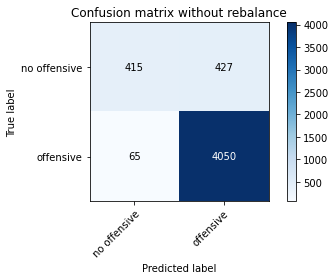

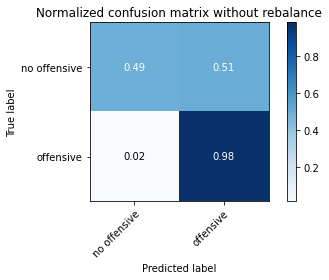

              precision    recall  f1-score   support

no offensive       0.86      0.49      0.63       842
   offensive       0.90      0.98      0.94      4115

    accuracy                           0.90      4957
   macro avg       0.88      0.74      0.79      4957
weighted avg       0.90      0.90      0.89      4957

training adversary 2 epoch...
893.2636218070984 seconds used......
2 training finished! train loss: 406.94186740298755
evaluating...
Confusion matrix, without normalization
[[ 645  197]
 [ 202 3913]]
Normalized confusion matrix
[[0.76603325 0.23396675]
 [0.0490887  0.9509113 ]]


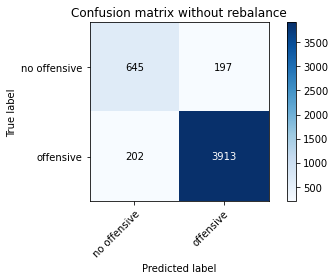

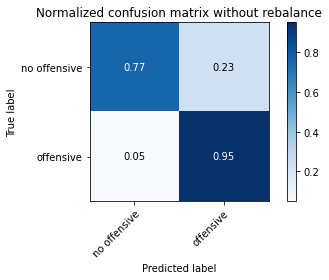

              precision    recall  f1-score   support

no offensive       0.76      0.77      0.76       842
   offensive       0.95      0.95      0.95      4115

    accuracy                           0.92      4957
   macro avg       0.86      0.86      0.86      4957
weighted avg       0.92      0.92      0.92      4957



In [20]:
adversary = adv_pretrain(classifier, adversary, 2, adv_optimizer, train_dataloader, test_dataloader)

In [22]:
torch.save(adversary, 'pretrained_adversary')

In [18]:
adversary = torch.load('pretrained_adversary')

## Joint training
In this step, only the total loss which is defined as L = L<sub>clf</sub> − α∗L<sub>adv</sub> is used for backpropagation. Hence, α is also a import hyperparameter. 

In [ ]:
epochs = 10
alpha = 0.05
model_name = 'adv_model_hate_as_offensive'
joint_training(classifier, adversary, epochs, clf_optimizer, adv_optimizer, train_dataloader, test_dataloader, alpha, model_name)

training 1 epoch...


##Rebalance the number of instances in classes
In the prevous experiment, rebalancing is an effective method to increase the true positive rate for hate speech class. (However, the scores of other classes will decrease)

In [ ]:
def rebalance_dataset(dataset):
    data_0 = [inst for inst in dataset if inst[2]==0]
    data_1 = [inst for inst in dataset if inst[2]==1]
    data_2 = [inst for inst in dataset if inst[2]==2]
    random.shuffle(data_0)
    random.shuffle(data_1)
    random.shuffle(data_2)
    num_data0 = len(data_0)
    balanced_dataset = data_0+data_1[:num_data0]+data_2[:num_data0]
    return balanced_dataset

In [ ]:
re_train_dataset = rebalance_dataset(train_dataset)
re_test_dataset = rebalance_dataset(test_dataset)

In [ ]:
batch_size = 10

In [ ]:
re_train_dataloader = DataLoader(re_train_dataset, sampler = RandomSampler(re_train_dataset), batch_size = batch_size)
re_test_dataloader = DataLoader(re_test_dataset, sampler = RandomSampler(re_test_dataset), batch_size = batch_size)

In [ ]:
epochs = 20
alpha = 0.0000005
model_name = 'adv_model'
joint_training(classifier, adversary, epochs, clf_optimizer, adv_optimizer, train_dataloader, test_dataloader, alpha, model_name)